In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bottleneck as bn
import scipy as sc
import os
#display machine this code is running on and current direcotry
print(os.uname())
print(os.getcwd())


posix.uname_result(sysname='Linux', nodename='sheep', release='6.5.0-41-generic', version='#41~22.04.2-Ubuntu SMP PREEMPT_DYNAMIC Mon Jun  3 11:32:55 UTC 2', machine='x86_64')
/tikhome/mgern/Desktop/ASM/electro-interfaces/code/dielectric_behavior


In [2]:
def read_file(file_path):
    charges = []
    positions = []
    # Read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Flag to indicate if we are in the ATOMS section
    in_atoms_section = False
    n_atoms = int(lines[3])

    # Loop through each line in the file
    for line in lines:
        # Check if the line starts with "ITEM: ATOMS"
        if line.startswith("ITEM: ATOMS"):
            in_atoms_section = True
            continue
        
        # If in the ATOMS section, extract the charge
        if in_atoms_section:
            if line.startswith("ITEM:"):  # If a new ITEM section starts, stop reading ATOMS
                in_atoms_section = False
            # Split the line by spaces and get the charge (last element)
            else:
                type = int(line.split()[1])
                charge = float(line.split()[-1])
                pos = np.array([float(x) for x in line.split()[2:5]])
                charges.append([charge,type])
                positions.append(pos)

    # Print the extracted charges
    charges=np.array(charges)
    positions = np.array(positions)
    charges =np.array([charges[i:i+n_atoms] for i in range(0, len(charges), n_atoms)])
    positions =np.array([positions[i:i+n_atoms] for i in range(0, len(positions), n_atoms)])
    return charges, positions
type = {1:"bottom wall", 2:"O", 3: "H",4:"Na", 5:"Cl", 6: "top wall"}  


def extract_polarisation(charges,positions):
    list = []
    for i in range(np.shape(charges)[0]):
        ind_top = charges[i,:,1]==1
        ind_bottom = charges[i,:,1]==6
        ind_O = charges[i,:,1]==2
        ind_H = charges[i,:,1]==3
        ind_Na = charges[i,:,1]==4
        ind_Cl = charges[i,:,1]==5

        charges_top = charges[i,ind_top,:]
        charges_bottom = charges[i,ind_bottom,:]
        charges_O = charges[i,ind_O,:]
        charges_H = charges[i,ind_H,:]
        charges_Na = charges[i,ind_Na,:]
        charges_Cl = charges[i,ind_Cl,:]

        position_O = positions[i,ind_O,:]
        position_H = positions[i,ind_H,:]
        position_Na = positions[i,ind_Na,:]
        position_Cl = positions[i,ind_Cl,:]
        dipole_O = np.sum(np.dot(charges_O[0,0],position_O),axis=0)
        dipole_H = np.sum(np.dot(charges_H[0,0],position_H),axis=0)
        dipole_Na = np.sum(np.dot(charges_Na[0,0],position_Na),axis=0)
        dipole_Cl = np.sum(np.dot(charges_Cl[0,0],position_Cl),axis=0)

        list.append([np.sum(charges_top[:,0]),np.sum(charges_bottom[:,0]),dipole_O,dipole_H,dipole_Na,dipole_Cl])
    return list

def plot_charge_top_wall(list, lf):
    start = list
    # plt.plot(start, label='data')
    plt.plot(bn.move_mean(start, window=100, min_count=1), label=f'move mean with lf = {lf}')
    def exponential_fit(t,tau_water,tau_ions,Q_infty,t_delay,A):
        return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty

    params = sc.optimize.curve_fit(exponential_fit, np.arange(len(start)), start, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
    plt.plot(np.arange(len(start)), exponential_fit(np.arange(len(start)), *params[0]), label=f'fit with lf = {lf}')
    plt.legend()
    print(f"lf = {lf}; tau_water = {params[0][0]}, tau_ions = {params[0][1]}, Q_infty = {params[0][2]}, t_delay = {params[0][3]}, A = {params[0][4]}")
    plt.title("charge on the top wall")


def plot_polarisation(list, lf):
    dipole_water = []
    dipole_ions = []
    dipole_solutes = []
    for t in range(len(list)):
        dipole_water.append(np.linalg.norm(list[t][2]+list[t][3]))
        dipole_ions.append(np.linalg.norm(list[t][4]+list[t][5]))
        dipole_solutes.append(np.linalg.norm(list[t][4]+list[t][5]+list[t][2]+list[t][3]))
    # plt.plot(dipole_water, label='water')
    # plt.plot(bn.move_mean(dipole_water, window=100, min_count=1), label='smoothed water')
    # # plt.plot(dipole_ions, label='ions')
    # plt.plot(bn.move_mean(dipole_ions, window=100, min_count=1), label='smoothed ions')
    # plt.plot(dipole_solutes, label='solutes')
    plt.plot(bn.move_mean(dipole_solutes, window=100, min_count=1), label=f'smoothed solutes with lf = {lf}')

    def exponential_fit(t,tau_water,tau_ions,Q_infty,t_delay,A):
        return A*(np.exp(-t/tau_water)-np.exp(-(t-t_delay)/tau_ions))+Q_infty

    params_solute = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_solutes)), dipole_solutes, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
    params_water = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_water)), dipole_water, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
    params_ions = sc.optimize.curve_fit(exponential_fit, np.arange(len(dipole_ions)), dipole_ions, maxfev=10000, method="dogbox", p0=[10,10,5,10,1])
    plt.plot(np.arange(len(dipole_solutes)), exponential_fit(np.arange(len(dipole_solutes)), *params_solute[0]), label=f'fit solutes with lf = {lf}')
    # plt.plot(np.arange(len(dipole_water)), exponential_fit(np.arange(len(dipole_water)), *params_water[0]), label='fit water')
    # plt.plot(np.arange(len(dipole_ions)), exponential_fit(np.arange(len(dipole_ions)), *params_ions[0]), label='fit ions')
    print(f"lf = {lf}; WATER ONLY:tau_water = {params_water[0][0]}, tau_ions = {params_water[0][1]}, Q_infty = {params_water[0][2]}, t_delay = {params_water[0][3]}, A = {params_water[0][4]}")
    print(f"lf = {lf}; IONS ONLY: tau_water = {params_ions[0][0]}, tau_ions = {params_ions[0][1]}, Q_infty = {params_ions[0][2]}, t_delay = {params_ions[0][3]}, A = {params_ions[0][4]}")
    print(f"lf = {lf}; BOTH: tau_water = {params_solute[0][0]}, tau_ions = {params_solute[0][1]}, Q_infty = {params_solute[0][2]}, t_delay = {params_solute[0][3]}, A = {params_solute[0][4]}")
    plt.legend()

def plot_charge_density(charges,positions,name):
    list = []
    for i in range(np.shape(charges)[0]):
        ind_O = charges[i,:,1]==2
        ind_H = charges[i,:,1]==3
        charges_O = charges[i,ind_O,0]/float(np.shape(charges)[0])
        charges_H = charges[i,ind_H,0]/float(np.shape(charges)[0])

        position_O = positions[i,ind_O,2]
        position_H = positions[i,ind_H,2]
        list.append([np.append(charges_H,charges_O),np.append(position_H,position_O)])
    list = np.array(list)

    density,bins,_ = plt.hist(np.mean(list[:,1,:],axis=0),bins=100,weights=np.mean(list[:,0,:],axis=0), label = name, alpha=0.5)
    return np.array(density),bins

def polarization_profile(density,bins,name):
    profile=np.zeros_like(density)
    
    for i in range(1,np.shape(density)[0]):
        profile[i]=sc.integrate.trapezoid(density[:i])

    plt.plot(bins[:-1],profile,label =name)
    return profile

In [3]:
data = read_file("wallcharge.lammpstrj")
list = extract_polarisation(data[0],data[1])
# plot_charge_top_wall([x[0] for x in list], 100)

charge on plate is 4.273716935547041, corresponds to an dielectric constant of 20.487617140685717


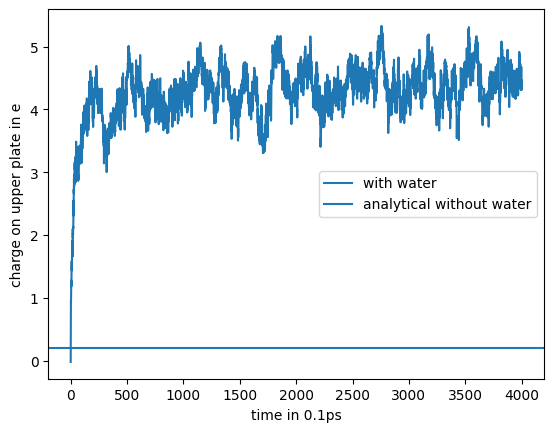

In [4]:
x=[list[i][0] for i in range(400,len(list))]
plt.plot(x,label="with water")
plt.axhline(0.2086,label = "analytical without water")
plt.legend()
plt.xlabel("time in 0.1ps")
plt.ylabel("charge on upper plate in e")
print(f"charge on plate is {np.mean(x)}, corresponds to an dielectric constant of {np.mean(x)/0.2086}")

In [5]:
eField_data = read_file("wallcharge_efield_act.lammpstrj")
noEField_data = read_file("wallcharge_efield.lammpstrj")


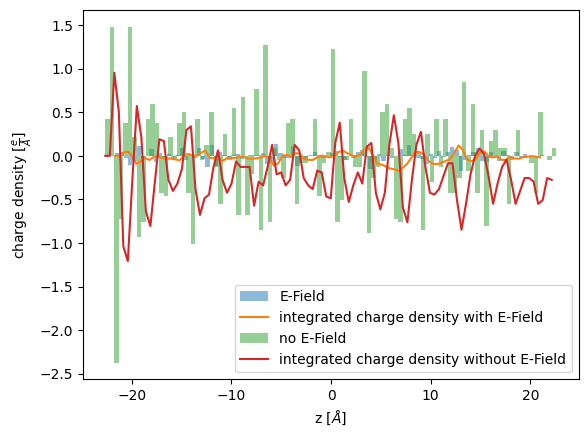

In [6]:
density,bins=plot_charge_density(eField_data[0],eField_data[1],"E-Field")
m=polarization_profile(density,bins, "integrated charge density with E-Field")
density,bins=plot_charge_density(noEField_data[0],noEField_data[1],"no E-Field")
m_zero= polarization_profile(density,bins, "integrated charge density without E-Field")
plt.xlabel(r"z [$\AA$]")
plt.ylabel(r"charge density [$\frac{e}{\AA}$]")
plt.legend()

Text(0, 0.5, 'dielectric profile ')

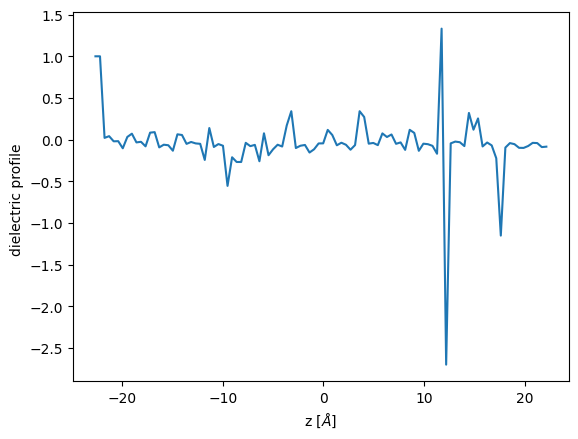

In [9]:
plt.plot(bins[:-1],0.02/(0.02-m+m_zero),label="difference")
plt.xlabel(r"z [$\AA$]")
plt.ylabel(r"dielectric profile ")